In [6]:
import os

In [7]:
import xarray as xr

In [ ]:
proj_string = xr.open_dataset("../data/mnt/forsite2/tas/tas_Austria_2020_250m_v2.nc").lambert_conformal_conic.attrs["spatial_ref"]

In [ ]:
args = [
    ("forsite2/tas/tas_Austria_{year}_250m_v2.nc", "tas", "air_temperature"),
    ("forsite2/pr/pr_Austria_{year}_250m_v2.1.nc", "pr", "precipitation"),
    ("forsite2/PET/PET_Austria_{year}_250m_v2.nc", "PET", "pot_evapotransp"),
    ("forsite2/wspd/wspd_{year}_250m.nc", "wspd", "wind_speed"),
    ("forsite2/hurs/hurs_Austria_{year}_250m_v2.nc", "hurs", "rel_humidity"),
]

In [ ]:
for year in range(2020, 2024):
    if (
        year == 2022
        # or os.path.exists(f"../data/input/{year}.zarr") don't skip because maybe not all variables finished
    ):
        continue
    for path, old_var_name, new_var_name in args:
        print(f"Working on year {year} and variable {new_var_name}...")
        (xr.open_dataset(os.path.join("../data/mnt", path.format(year=year)))[old_var_name]
           .rename(new_var_name).rio.write_crs(proj_string)
           .chunk(chunks={"time": -1, "x": 41, "y": 37})
           .to_zarr(f"../data/input/{year}.zarr", mode="a-"))
        print("...done.")

Working on year 2021 and variable air_temperature...


KeyboardInterrupt: 

In [22]:
args

[('tas/tas_Austria_{year}_250m_v2.nc', 'tas', 't2m')]

In [10]:
"lskdjf{a}slkdjf".format(b=45)

KeyError: 'a'

In [ ]:
def append_observable_to_year_zarr()

In [2]:
t2m = xr.open_dataset("../data/mnt/forsite2/tas/tas_Austria_2020_250m_v2.nc")#, chunks={"time": -1, "x": 100, "y": 100}
t2m

<xarray.Dataset> Size: 8GB
Dimensions:                  (x: 2296, y: 1184, time: 366)
Coordinates:
  * x                        (x) float64 18kB 1.121e+05 1.124e+05 ... 6.859e+05
  * y                        (y) float64 9kB 2.751e+05 2.753e+05 ... 5.708e+05
  * time                     (time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
Data variables:
    lambert_conformal_conic  |S1 1B ...
    lat                      (y, x) float64 22MB ...
    lon                      (y, x) float64 22MB ...
    tas                      (time, y, x) float64 8GB ...
Attributes:
    title:        Project FORSITE II
    institution:  BOKU-Met, Institute of Meteorology, University of Natural R...
    contact:      Fabian Lehner (fabian.lehner@boku.ac.at), Herbert Formayer ...

In [3]:
proj_string = t2m.lambert_conformal_conic.attrs["spatial_ref"]

In [4]:
t2m = t2m.tas.rio.write_crs(proj_string)
t2m

<xarray.DataArray 'tas' (time: 366, y: 1184, x: 2296)> Size: 8GB
[994957824 values with dtype=float64]
Coordinates:
  * x            (x) float64 18kB 1.121e+05 1.124e+05 ... 6.856e+05 6.859e+05
  * y            (y) float64 9kB 2.751e+05 2.753e+05 ... 5.706e+05 5.708e+05
  * time         (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
    spatial_ref  int64 8B 0

In [5]:
t2m.chunk(chunks={"time": 61, "x": 1148, "y": 592}).to_zarr("../data/input/Zarr", mode="a-")#, append_dim="time"

In [169]:
pr = xr.open_dataset("../data/mnt/forsite2/pr/pr_Austria_2019_250m_v2.1.nc").pr#, chunks={"time": -1, "x": 100, "y": 100}
pr

<xarray.DataArray 'pr' (time: 365, y: 1184, x: 2296)> Size: 4GB
[992239360 values with dtype=float32]
Coordinates:
  * x        (x) float64 18kB 1.121e+05 1.124e+05 ... 6.856e+05 6.859e+05
  * y        (y) float64 9kB 2.751e+05 2.753e+05 ... 5.706e+05 5.708e+05
  * time     (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31

In [6]:
pr = xr.open_dataset("../data/mnt/forsite2/pr/pr_Austria_2020_250m_v2.1.nc").pr#, chunks={"time": -1, "x": 100, "y": 100}
pr

<xarray.DataArray 'pr' (time: 366, y: 1184, x: 2296)> Size: 4GB
[994957824 values with dtype=float32]
Coordinates:
  * x        (x) float64 18kB 1.121e+05 1.124e+05 ... 6.856e+05 6.859e+05
  * y        (y) float64 9kB 2.751e+05 2.753e+05 ... 5.706e+05 5.708e+05
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31

In [170]:
pr.chunk(chunks={"time": 61, "x": 1148, "y": 592}).to_zarr("../data/input/Zarr", mode="a-")#, append_dim="time"

ValueError: variable 'time' already exists with different dimension sizes: {'time': 731} != {'time': 365}. to_zarr() only supports changing dimension sizes when explicitly appending, but append_dim=None. If you are attempting to write to a subset of the existing store without changing dimension sizes, consider using the region argument in to_zarr().

In [168]:
tmp = xr.open_dataset("../data/input/Zarr", decode_coords="all", engine="zarr", chunks={})
tmp

ValueError: conflicting sizes for dimension 'time': length 731 on 'tas' and length 366 on {'time': 'pr', 'y': 'pr', 'x': 'pr'}

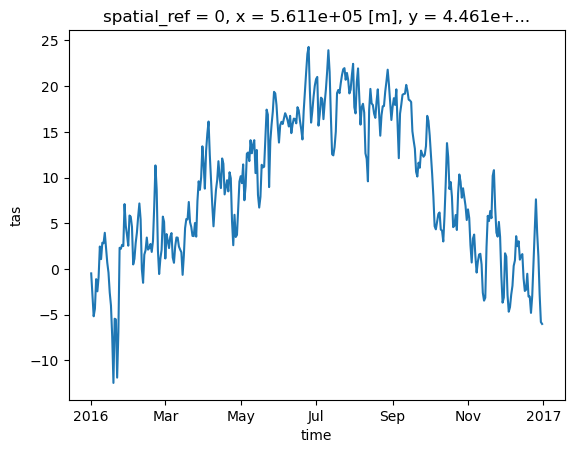

In [121]:
tmp.isel(x=-500, y=-500).sel(time="2016").plot()

In [10]:
t2m.drop_encoding()

<xarray.DataArray 'tas' (time: 366, y: 1184, x: 2296)> Size: 8GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 18kB 1.121e+05 1.124e+05 ... 6.856e+05 6.859e+05
  * y            (y) float64 9kB 2.751e+05 2.753e+05 ... 5.706e+05 5.708e+05
  * time         (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
    spatial_ref  int64 8B 0

In [ ]:
# t2m["time"] = t2m.time.astype("int")

In [30]:
from dask import array as da

In [35]:
da_ = da.from_array(t2m, chunks=(61, 592, 1148))
da_

dask.array<array, shape=(366, 1184, 2296), dtype=float64, chunksize=(61, 592, 1148), chunktype=xarray.DataArray>

In [46]:
import numpy as np
import pandas as pd

In [47]:
ds = xr.Dataset(
    {"foo": (("x", "y"), np.random.rand(4, 5))},
    coords={
        "x": [10, 20, 30, 40],
        "y": pd.date_range("2000-01-01", periods=5),
        "z": ("x", list("abcd")),
    },
)


ds.to_zarr("path/to/directory.zarr")

In [52]:
tmp = t2m[:10,:20,:30]
tmp

<xarray.DataArray 'tas' (time: 10, y: 20, x: 30)> Size: 48kB
[6000 values with dtype=float64]
Coordinates:
  * x            (x) float64 240B 1.121e+05 1.124e+05 ... 1.191e+05 1.194e+05
  * y            (y) float64 160B 2.751e+05 2.753e+05 ... 2.796e+05 2.798e+05
  * time         (time) datetime64[ns] 80B 2020-01-01 2020-01-02 ... 2020-01-10
    spatial_ref  int64 8B 0

In [53]:
tmp.to_zarr("test1.zarr")

In [78]:
[x//4
#  *4-x 
 for x in  t2m.shape]

[91, 296, 574]

In [87]:
t2m.chunk(chunks={"time": 30, "x": 574, "y": 296}).to_zarr("../data/input/2010.zarr", mode="a-")

In [90]:
t2m.to_zarr("../data/input/2010.zarr", mode="a-")

In [ ]:
t2mv.to_zarr("../data/input/2010.zarr", mode="a-")

In [76]:
t2m.rename("test").to_zarr("../data/input/2010.zarr", mode="a-")

In [77]:
t2m.chunk(chunks={"time": 61, "x": 287, "y": 148}).to_zarr("../data/input/2010.zarr", mode="a-")

In [82]:
t2m.chunk(chunks={"time": 366, "x": 574, "y": 296}).to_zarr("../data/input/2010.zarr", mode="a-")

In [81]:
t2m.chunk(chunks={"time": 92, "x": 574, "y": 296}).to_zarr("../data/input/2010.zarr", mode="a-")

In [11]:
365*37*41

553705

In [7]:
1184/2/2/2/2/2


37.0

In [10]:
2296/2/2/2/7

41.0

In [2]:
import numpy as np

In [ ]:
np.prim

In [ ]:
t2m.chunk(chunks={"time": 45, "x": 287, "y": 148}).to_zarr("../data/input/2010.zarr", mode="a-")

/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'h5netcdf' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)


CPU times: user 308 ms, sys: 14.9 ms, total: 323 ms
Wall time: 247 ms
CPU times: user 107 ms, sys: 9.93 ms, total: 117 ms
Wall time: 30.5 ms


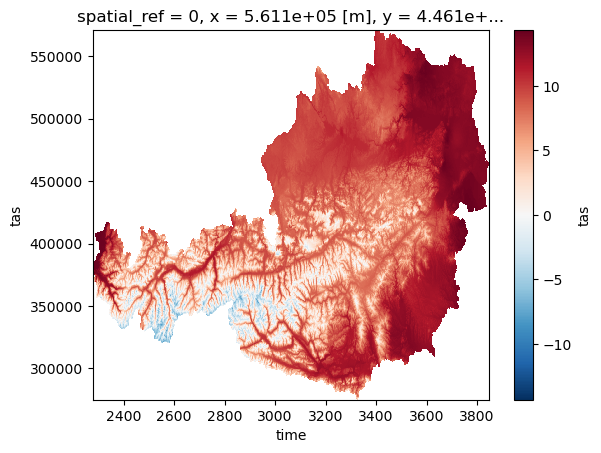

In [89]:
tmp = xr.open_dataarray("../data/input/2010.zarr", decode_coords="all")

%time tmp.isel(time=150).plot()
%time tmp.isel(x=-500, y=-500).plot()

/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'h5netcdf' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)


CPU times: user 288 ms, sys: 70.1 ms, total: 358 ms
Wall time: 560 ms
CPU times: user 19.1 ms, sys: 4.41 ms, total: 23.5 ms
Wall time: 12.7 ms


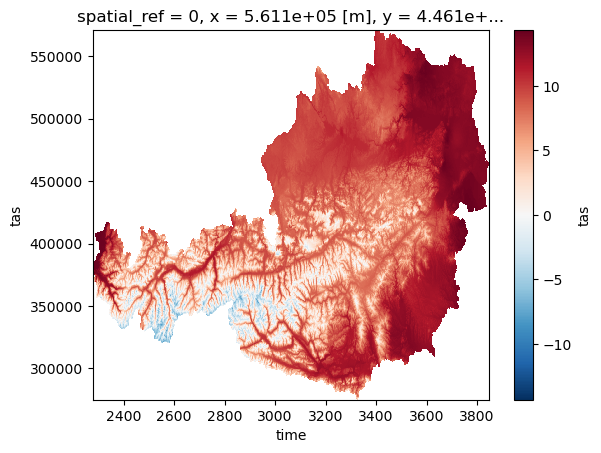

In [91]:
tmp = xr.open_dataarray("../data/input/2010.zarr", decode_coords="all")

%time tmp.isel(time=150).plot()
%time tmp.isel(x=-500, y=-500).plot()

/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'h5netcdf' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)


CPU times: user 267 ms, sys: 28.6 ms, total: 296 ms
Wall time: 299 ms
CPU times: user 17 ms, sys: 3.62 ms, total: 20.7 ms
Wall time: 8.6 ms


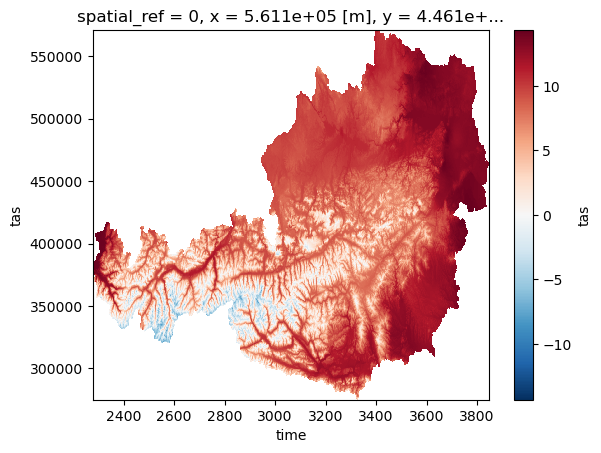

In [93]:
tmp = xr.open_dataarray("../data/input/2010.zarr", decode_coords="all")

%time tmp.isel(time=150).plot()
%time tmp.isel(x=-500, y=-500).plot()

/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'h5netcdf' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)


CPU times: user 335 ms, sys: 185 ms, total: 520 ms
Wall time: 315 ms
CPU times: user 187 ms, sys: 265 ms, total: 451 ms
Wall time: 156 ms


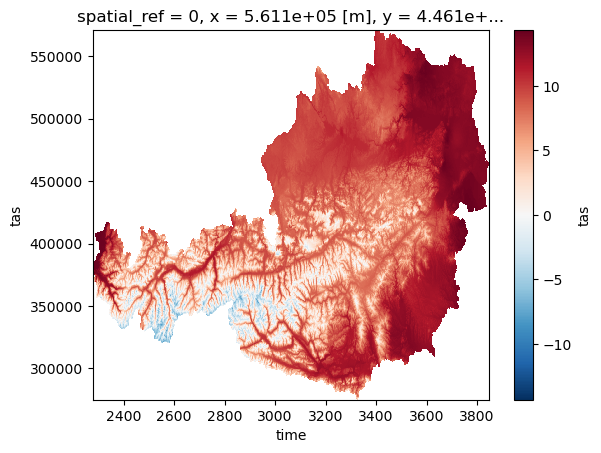

In [97]:
tmp = xr.open_dataarray("../data/input/2010.zarr", decode_coords="all")

%time tmp.isel(time=150).plot()
%time tmp.isel(x=-500, y=-500).plot()

In [ ]:
tmp = xr.open_dataarray("../data/input/2010.zarr", decode_coords="all")

%time tmp.isel(time=150).plot()
%time tmp.isel(x=-500, y=-500).plot()

In [40]:
import zarr

In [42]:
store = zarr.DirectoryStore("../data/input/2010.zarr")

In [45]:
t2m.to_zarr(store, "w")

ContainsArrayError: path '' contains an array

In [ ]:
da_ = da.from_array(t2m.chunk(chunks={"time": 61, "x": 1148, "y": 592}))
da_

/home/haacker/miniforge3/envs/devel/lib/python3.12/site-packages/dask/array/core.py:3625: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(


dask.array<array, shape=(366, 1184, 2296), dtype=float64, chunksize=(45, 437, 851), chunktype=xarray.DataArray>

In [26]:
t2m.isel(time=slice(360)).drop_encoding().chunk(chunks={"time": 60, "x": 1148, "y": 592}).to_zarr(f"../data/input/2010.zarr/", "w")

In [25]:
tmp = xr.open_zarr(f"../data/input/2010.zarr/", decode_times=False, decode_coords="all", use_cftime=True)
tmp

FileNotFoundError: No such file or directory: '/home/haacker/CropShift/data/input/2010.zarr'

In [20]:
tmp.tas.isel(time=150)

<xarray.DataArray 'tas' (y: 1184, x: 2296)> Size: 22MB
dask.array<getitem, shape=(1184, 2296), dtype=float64, chunksize=(592, 1148), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B ...
    time         int64 8B 1590796800000000000
  * x            (x) float64 18kB nan nan nan nan nan ... nan nan nan nan nan
  * y            (y) float64 9kB nan nan nan nan nan nan ... nan nan nan nan nan

In [22]:
(~t2m.isel(time=150).isnull()).sum()

<xarray.DataArray 'tas' ()> Size: 8B
array(1371812)
Coordinates:
    time         datetime64[ns] 8B 2020-05-30
    spatial_ref  int64 8B 0

In [24]:
(~tmp.tas.isel(time=150).isnull()).sum().compute()

<xarray.DataArray 'tas' ()> Size: 8B
array(0)
Coordinates:
    spatial_ref  int64 8B 0
    time         int64 8B 124185490665328

In [25]:
xr.__version__

'2024.10.0'